In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier

# Base models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

sns.set(style="whitegrid")

In [2]:
# Load data (adjust paths as needed)
train_df = pd.read_csv("Final_data/train_data.csv")
dev_df = pd.read_csv("Final_data/dev_data.csv")
test_df = pd.read_csv("Final_data/test_data.csv")

# Check column names (assume text is in "claim" and labels in "label")
print("Train columns:", train_df.columns)
print("Dev columns:", dev_df.columns)

# For example, if labels are numeric (0 or 1) and text is in "claim"
train_texts = train_df["claim"].tolist()
dev_texts = dev_df["claim"].tolist()
test_texts = test_df["claim"].tolist()

# If labels need encoding (if they are strings), use LabelEncoder. Otherwise, assume they're already numeric.
if train_df["label"].dtype == object:
    label_encoder = LabelEncoder()
    all_labels = pd.concat([train_df["label"], dev_df["label"], test_df["label"]], axis=0)
    label_encoder.fit(all_labels)
    y_train = label_encoder.transform(train_df["label"])
    y_dev = label_encoder.transform(dev_df["label"])
    y_test = label_encoder.transform(test_df["label"])
else:
    y_train = train_df["label"].values
    y_dev = dev_df["label"].values
    y_test = test_df["label"].values

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts)
X_dev = vectorizer.transform(dev_texts)
X_test = vectorizer.transform(test_texts)

# Save vectorizer for later use
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("TF-IDF features extracted:")
print("Train shape:", X_train.shape)
print("Dev shape:", X_dev.shape)
print("Test shape:", X_test.shape)

Train columns: Index(['claim_id', 'claim', 'main_text', 'label', 'claim-p', 'postagged'], dtype='object')
Dev columns: Index(['claim_id', 'claim', 'main_text', 'label', 'claim-p', 'postagged'], dtype='object')
TF-IDF features extracted:
Train shape: (5341, 5000)
Dev shape: (2226, 5000)
Test shape: (1336, 5000)


In [3]:
# Define a helper function to build a bagging model
def build_bagging_model(base_estimator, n_estimators=10, random_state=42):
    return BaggingClassifier(estimator=base_estimator, n_estimators=n_estimators, random_state=random_state)

# 1. Bagging with Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
bagging_logreg = build_bagging_model(logreg, n_estimators=10)
bagging_logreg.fit(X_train, y_train)
print("Bagging Logistic Regression trained!")

# 2. Bagging with Multinomial Naive Bayes
nb = MultinomialNB()
bagging_nb = build_bagging_model(nb, n_estimators=10)
bagging_nb.fit(X_train, y_train)
print("Bagging Naive Bayes trained!")

# 3. Bagging with Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
bagging_dt = build_bagging_model(dt, n_estimators=10)
bagging_dt.fit(X_train, y_train)
print("Bagging Decision Tree trained!")

# 4. Bagging with k-Nearest Neighbors
# knn = KNeighborsClassifier(n_neighbors=5)
# bagging_knn = build_bagging_model(knn, n_estimators=10)
# bagging_knn.fit(X_train, y_train)
# print("Bagging k-Nearest Neighbors trained!")
### This was hurting performance

# 5. Bagging with Support Vector Classifier (with probability estimates)
svc = SVC(probability=True, random_state=42)
bagging_svc = build_bagging_model(svc, n_estimators=10)
bagging_svc.fit(X_train, y_train)
print("Bagging SVC trained!")

Bagging Logistic Regression trained!
Bagging Naive Bayes trained!
Bagging Decision Tree trained!
Bagging SVC trained!


In [4]:
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y, y_pred, zero_division=1))
    return y_pred, acc

In [5]:
pred_logreg, acc_logreg = evaluate_model(bagging_logreg, X_dev, y_dev, "Bagging Logistic Regression")

Bagging Logistic Regression Accuracy: 0.7372
Bagging Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       844
           1       0.75      0.86      0.80      1382

    accuracy                           0.74      2226
   macro avg       0.73      0.70      0.71      2226
weighted avg       0.73      0.74      0.73      2226



In [6]:
pred_nb, acc_nb = evaluate_model(bagging_nb, X_dev, y_dev, "Bagging Naive Bayes")

Bagging Naive Bayes Accuracy: 0.7435
Bagging Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.54      0.62       844
           1       0.76      0.87      0.81      1382

    accuracy                           0.74      2226
   macro avg       0.73      0.70      0.71      2226
weighted avg       0.74      0.74      0.73      2226



In [7]:
pred_dt, acc_dt = evaluate_model(bagging_dt, X_dev, y_dev, "Bagging Decision Tree")

Bagging Decision Tree Accuracy: 0.7165
Bagging Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       844
           1       0.75      0.81      0.78      1382

    accuracy                           0.72      2226
   macro avg       0.70      0.69      0.69      2226
weighted avg       0.71      0.72      0.71      2226



In [9]:
pred_svc, acc_svc = evaluate_model(bagging_svc, X_dev, y_dev, "Bagging SVC")

Bagging SVC Accuracy: 0.7457
Bagging SVC Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       844
           1       0.77      0.84      0.80      1382

    accuracy                           0.75      2226
   macro avg       0.73      0.72      0.72      2226
weighted avg       0.74      0.75      0.74      2226



In [10]:
# Combine predictions from all five bagging models using majority voting
all_preds = np.vstack((pred_logreg, pred_nb, pred_dt, pred_svc)).T  # shape: (n_samples, 5)

def majority_vote(preds):
    # Use np.bincount to find the majority vote for each sample
    return np.array([np.bincount(row).argmax() for row in preds])

ensemble_preds = majority_vote(all_preds)
ensemble_acc = accuracy_score(y_dev, ensemble_preds)
print("Ensemble Bagging Accuracy on Dev Set:", ensemble_acc)
print("Ensemble Classification Report:")
print(classification_report(y_dev, ensemble_preds, zero_division=1))

Ensemble Bagging Accuracy on Dev Set: 0.7497753818508536
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65       844
           1       0.78      0.84      0.81      1382

    accuracy                           0.75      2226
   macro avg       0.74      0.72      0.73      2226
weighted avg       0.75      0.75      0.75      2226



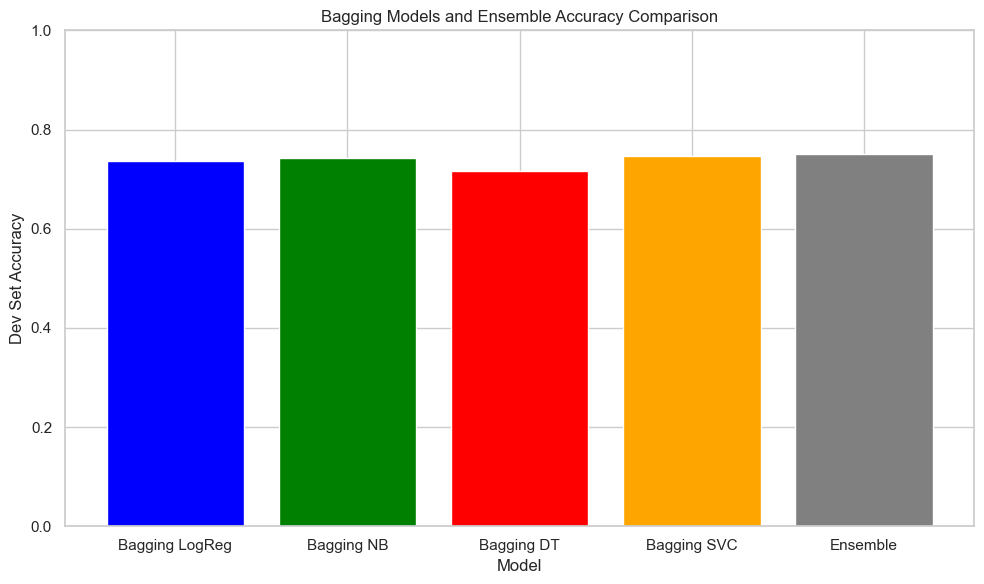

In [11]:
# Collect individual model accuracies
model_names = ["Bagging LogReg", "Bagging NB", "Bagging DT", "Bagging SVC", "Ensemble"]
accuracies = [acc_logreg, acc_nb, acc_dt, acc_svc, ensemble_acc]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=["blue", "green", "red", "orange", "gray"])
plt.xlabel("Model")
plt.ylabel("Dev Set Accuracy")
plt.title("Bagging Models and Ensemble Accuracy Comparison")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [12]:
import pickle

# Combine all bagging models into a dictionary
bagging_models = {
    "logreg": bagging_logreg,
    "nb": bagging_nb,
    "dt": bagging_dt,
    # "knn": bagging_knn,
    "svc": bagging_svc
}

# Save the dictionary as a single pickle file
with open("final_bagging_models.pkl", "wb") as f:
    pickle.dump(bagging_models, f)

print("All bagging models have been saved together in 'final_bagging_models.pkl'.")

All bagging models have been saved together in 'final_bagging_models.pkl'.
